<a href="https://colab.research.google.com/github/prettyangell/Recherche-Exacte-de-Motifs/blob/main/projet_bio_algo_Bouhraoua_hamdi_pacha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Les imports

In [ ]:
from pprint import pprint
import random
import pandas as pd
import os.path
import csv
import time
import sys
import matplotlib.pyplot as plt

# Algorithme naif
parcours tout le texte en faisant glisser la fenetre caractère par caractère

In [ ]:
def naive_search(text, pattern):
    comp=0
    n = len(text)
    m = len(pattern)
    for i in range(n - m + 1):
        match = True
        for j in range(m):
            comp+=1
            if text[i+j] != pattern[j]:
                match = False
                break
        if match:
            return i,comp

# Boyer More

## Algorithmes

### fonction de construction de dictionnaire

In [ ]:
def const_dic(motif):
    m=len(motif)
    d={}
    alpha=set(motif)
    max_index={x:-1 for x in alpha}
    for i in range(m):
        for k in alpha:
            d[(i,k)]=max_index[k]
        max_index[motif[i]]=i
    return d,alpha


In [ ]:
# Exemple d'utilisation
pprint(const_dic("ATCATGAG"))

({(0, 'A'): -1,
  (0, 'C'): -1,
  (0, 'G'): -1,
  (0, 'T'): -1,
  (1, 'A'): 0,
  (1, 'C'): -1,
  (1, 'G'): -1,
  (1, 'T'): -1,
  (2, 'A'): 0,
  (2, 'C'): -1,
  (2, 'G'): -1,
  (2, 'T'): 1,
  (3, 'A'): 0,
  (3, 'C'): 2,
  (3, 'G'): -1,
  (3, 'T'): 1,
  (4, 'A'): 3,
  (4, 'C'): 2,
  (4, 'G'): -1,
  (4, 'T'): 1,
  (5, 'A'): 3,
  (5, 'C'): 2,
  (5, 'G'): -1,
  (5, 'T'): 4,
  (6, 'A'): 3,
  (6, 'C'): 2,
  (6, 'G'): 5,
  (6, 'T'): 4,
  (7, 'A'): 6,
  (7, 'C'): 2,
  (7, 'G'): 5,
  (7, 'T'): 4},
 {'T', 'A', 'C', 'G'})


###fonction de décalage

In [ ]:
def decalage(alpha,d,j,c):
    if c in alpha:
        return j-d[(j,c)]
    else:
        return j+1

### fonction de recherche

In [ ]:
def Boyer_Moore(text: str,motif: str):
    m=len(motif)
    n=len(text)

    # Etape 1: construction de dictionnaire
    d,alpha=const_dic(motif)

    i = 0
    n_comp=0
    while i <= n - m :
        k = 0
        j = m - 1
        while j >= 0:
            n_comp+=1
            # print(text[i+j],i+j,motif[j],j)
            if text[i + j] != motif[j]:
                k = decalage(alpha,d, j, text[j+i])
                break
            if j==0:
                return i,n_comp,d
            j -= 1
        i += k
    return None

In [ ]:
# Exemple d'utilisation
text = "stupid_spring_string"
pattern="string"
res,comp,_=Boyer_Moore(text,pattern)
print("Positions des occurrences:", res)
print("Nombre de comparaisons effectuées:", comp)

Positions des occurrences: 14
Nombre de comparaisons effectuées: 14


# Rabin karp

fonctions communes

In [ ]:
def hash(s, b, q):
    # Fonction de hachage
    h = 0
    for char in s:
        h=h*b+ord(char)

    return h%q

def rehash(old_char, new_char, old_hash, b, q, length):
    # Recalcul du hachage pour la nouvelle fenêtre
    old_char_val = ord(old_char)
    new_char_val = ord(new_char)
    h = (old_hash-(old_char_val*(b**(length-1))))*b+new_char_val
    return h % q

## Avec une fonction de hashage (sans filtre de bloom)

In [ ]:
def rabin_karp(text, motifs, b, q):
    # Vérification des tailles des motifs
    motif_length = len(motifs[0])
    for motif in motifs[1:]:
        if len(motif) != motif_length:
            raise ValueError("Les motifs doivent avoir la même taille")

    positions = {}
    comparisons = 0
    faux_pos=0
    n = len(text)

    # Calculer les hachages pour chaque motif
    motif_hashes = {motif: hash(motif, b, q) for motif in motifs}
    # Calculer le hachage du texte pour la première fenêtre
    ht = hash(text[:motif_length], b, q)
    # Parcourir le texte en calculant le hachage de chaque fenêtre et le comparer avec les hachages des motifs
    for i in range(n - motif_length+1):
        for motif, hm in motif_hashes.items():
            if hm == ht:
                match = True
                for j in range(motif_length):
                    comparisons += 1
                    if text[i+j] != motif[j]:
                        match = False
                        break
                if match:
                    positions[motif] = [i] # Correspondance trouvée
                    break
                else:
                  faux_pos+=1

        if i < n - motif_length:
            # Recalcul du hachage pour la prochaine fenêtre
            ht = rehash(text[i], text[i+motif_length], ht, b, q, motif_length)

    return positions, comparisons,faux_pos



In [ ]:
# Exemple d'utilisation
text = "stupid_spring_string"
patterns = ["stupid","string"]
b = 10  # Base
q = 11   # Nombre approprié
res,comp,faux_pos=rabin_karp(text,patterns,b,q)
print("Positions des occurrences:", res)
print("Nombre de comparaisons effectuées:", comp)
print(f"faux positif:{faux_pos}")

Positions des occurrences: {'stupid': [0], 'string': [14]}
Nombre de comparaisons effectuées: 13
faux positif:1


## Avec 3 fonctions de hashage (avec filtre de bloom)

In [ ]:
def rabin_karp_bloom(text, motifs, hash_functions):
    # Vérification des tailles des motifs
    motif_length = len(motifs[0])
    for motif in motifs[1:]:
        if len(motif) != motif_length:
            raise ValueError("Les motifs doivent avoir la même taille")

    positions = {}
    comparisons = 0
    faux_pos=0
    n = len(text)

    # Initialisation du vecteur bloom
    bloom = {}

    # Calculer les hachages pour chaque motif avec chaque fonction de hachage
    for motif in motifs:
        bloom[motif] = [hash(motif, b, q) for b, q in hash_functions]


    # Parcourir le texte
    for i in range(n - motif_length + 1):
        # Calculer le hachage de la fenêtre actuelle
        current_hashes = [hash(text[i:i+motif_length], b, q) for b, q in hash_functions]
        # Vérifier si le hachage de la fenêtre actuelle correspond à l'un des hachages des motifs
        for motif in motifs:
            if all(ht == ch for ht, ch in zip(bloom[motif], current_hashes)):
                # Vérifier la correspondance caractère par caractère
                match = True
                for j in range(motif_length):
                    comparisons += 1
                    if text[i+j] != motif[j]:
                        match = False
                        break
                if match:
                    if motif not in positions:
                        positions[motif] = [i]
                    else:
                        positions[motif].append(i)   # Correspondance trouvée
                else:
                  faux_pos+=1


    return positions, comparisons,faux_pos


Exemple

In [ ]:
# Exemple d'utilisation

text = "ABABDABACDABABCABAB"
motifs = ["AB", "CA"]
hash_functions = [(257, 101), (263, 103)]
positions, comparisons,faux_pos= rabin_karp_bloom(text, motifs, hash_functions)
print("Positions:", positions)
print("Comparisons:", comparisons)
print(f"Faux positifs:{faux_pos}")

Positions: {'AB': [0, 2, 5, 10, 12, 15, 17], 'CA': [14]}
Comparisons: 16
Faux positifs:0


# Aho Corasik


##Table des  préfixes

In [ ]:
from typing import List
def prefm(M:List[str]):
  output = []
  for word in M:
    for i in range(1,len(word)+1):
      if word[:i] not in output:
        output.append(word[:i])
  output.sort(key=lambda x : len(x))
  return output


In [ ]:
thing = prefm(['at','tatt','tt'])
#thing.sort(key=lambda x : len(x))
print(thing)

['a', 't', 'at', 'ta', 'tt', 'tat', 'tatt']


##fonction de suppliance

In [ ]:
from typing import List

def echec (prefixes:List[str]):
  suppliance = {}
  for prefix in prefixes:
    for i in range(1,len(prefix)):
      suffix = prefix[i:]
      if suffix in prefixes:
        suppliance[prefix]=suffix
        break
    if suppliance.get(prefix) is None:
      suppliance[prefix]=''
  # suppliance =
  return suppliance



In [ ]:
echec(prefm(['at','tatt','tt']))

{'a': '', 't': '', 'at': 't', 'ta': 'a', 'tt': 't', 'tat': 'at', 'tatt': 'tt'}

##Table de sortie

In [ ]:
from typing import List

def sortie(prefixes:List[str], words:List[str]):
  # output dictionary initilization
  output={}
  # for each prefix in the prefixes table (list)
  for prefix in prefixes:
    # we initialize the output of the prefix as empty
    output[prefix] = []
    # foreach suffix of the current prefix
    for i in range(len(prefix)):
      suffix = prefix[i:]
      # if the suffix belongs to the final words, we append it
      if suffix in words:
        output[prefix].append(suffix)

  return output


In [ ]:
# example output
sortie(prefm(['at','tatt','tt']),['at','tatt','tt'])

{'a': [],
 't': [],
 'at': ['at'],
 'ta': [],
 'tt': ['tt'],
 'tat': ['at'],
 'tatt': ['tatt', 'tt']}

##Automate

###Noeud

In [ ]:
from typing import Dict

class Noeud():
  def __init__(self,name = '',nexts = {}, final=False):
    self.name = name
    self.nexts = nexts
    self.final = final

  def next(self, char):
    if self.nexts.get(char) is not None:
      return self.nexts.get(char)
    else:
      return None

  def __str__(self):
    return self.name

  @property
  def transitions(self):
    return [*self.nexts.keys]

  def addNext(self,char,final=False):
    if self.nexts.get(char) is not None:
      raise Exception("Char path Node already exists")
    else:
      successor = Noeud(self.name+ char, {}, final)
      self.nexts[char] = successor
      return successor

  def setNext(self, char:str, next):
    self.nexts[char] = next


###Arbre

In [ ]:

class Arbre():
  def __init__(self, root:Noeud):
    self.root = root
    self.nodes = {'':root}
    self.cursor = root
    self.words = []

  def addWord(self, word:str):
    # initalize the cursor to the root node
    self.words.append(word)
    self.cursor = self.root

    for i in range(len(word)):
      letter = word[i]
      final = False
      # si c'est le dernier caractère, le noeud est final
      if i == len(word) - 1:
        final = True
      # si le cursor n'a pas de successeur
      if self.cursor.next(letter) is None:
        self.cursor = self.cursor.addNext(letter, final)
        self.nodes[self.cursor.name] = self.cursor
      else:
        self.cursor =self.cursor.next(letter)

    self.cursor = self.root
    # self.optimizeRoutes()

  def setWords(self, words):
    for word in words:
      self.addWord(word)

    self.prefixes = prefm(self.words)
    self.supliance = echec(self.prefixes)
    self.tableSortie = sortie(self.prefixes, self.words)
    self.optimizeRoutes()


  def __str__(self):
    return str(self.root)

  def search(self,text:str):
    self.cursor = self.root
    indicies = {}
    i=0
    while i < len(text):
      letter = text[i]
      if self.cursor.next(letter) is None:
        # cas non trouvé
        if self.cursor.next('') is not None:
          # si une transition vide existe, on transitionnne
          self.cursor = self.cursor.next('')
        else:
          # dans le cas contraire on avance dans le texte
          # on sait qu'on revient à root
          i+=1
      else:
        # cas trouvé
        self.cursor = self.cursor.next(letter)
        i+=1

      if self.cursor.final:
        foundWords = self.tableSortie[self.cursor.name]
        for foundWord in foundWords:
          index = i - len(foundWord) + 1
          if indicies.get(foundWord) is None:
            indicies[foundWord] = [index]
          else:
            if index not in indicies[foundWord]:
              indicies[foundWord].append(index)

    return indicies



  def optimizeRoutes(self):
    prefixes = self.prefixes
    supliance = self.supliance
    # self.tableSortie = self.tableSortie

    for prefix in supliance:
      try:
        self.nodes[prefix].setNext(
            '',
            self.nodes[supliance[prefix]]
            )
      except:
        print(self.nodes)
        print(prefix)
        import sys
        sys.exit("Error message")

    for item in self.tableSortie:
      if self.tableSortie[item] != []:
        try:
          self.nodes[item].final = True
        except:
          print(str(self.tableSortie))


  def print(self):
    import networkx as nx
    DG = nx.DiGraph()
    for node in self.nodes:
      DG.add_node(node)

    for node in self.nodes:
      for edge in self.nodes[node].nexts:
        end = self.nodes[node].nexts[edge]
        DG.add_edge(node,end.name)

    nx.draw(DG, with_labels=True)


  def readChar(self, char:str):
    return self.cursor.next(char)



In [ ]:
def draw_graph(tree:Arbre):
  import networkx as nx
  import matplotlib.pyplot as plt
  # import pydot
  # from networkx.drawing.nx_pydot import graphviz_layout
  G = nx.DiGraph()

  plt.figure(figsize=(10, 5))


  end = 'red'
  root = 'green'
  normal = 'blue'

  labels = {}

  nodeList = []
  color_map = []

  # fill nodeList and color_map
  for prefix in tree.nodes:
    node = tree.nodes[prefix]
    nodeList.append(prefix)
    if prefix == '':
      color_map.append(root)
    else:
      if node.final:
        color_map.append(end)
      else:
        color_map.append(normal)

  G.add_nodes_from(nodeList)

  # specify edges
  for prefix in tree.nodes:
    node = tree.nodes[prefix]
    for transition in node.nexts:
      if transition == '':
        G.add_edge(node.name, node.next('').name, color='red')
      else:
        G.add_edge(node.name, node.next(transition).name, color='black')
        labels[(node.name, node.next(transition).name)]= transition

  #  getting the color for edges and puting them into  a list
  colors = nx.get_edge_attributes(G, 'color').values()

  # tebe3t yacine
  pos = nx.kamada_kawai_layout(G)

  nx.draw_networkx_edge_labels(
        G, pos, edge_labels=labels, font_size=15)

  nx.draw_networkx(G, pos, edge_color=colors,
                     connectionstyle="arc3,rad=0.2")

  # to change noud color
  print("color_map length" + str(len(color_map)))
  print("tree.nodes length" + str(len(tree.nodes)))
  print(G.nodes)
  nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=500)
  # just to chnage noud lables color
  nx.draw_networkx_labels(G, pos, font_color='#000')
  plt.show()


###Test


####Exemple

color_map length10
tree.nodes length10
['', 'B', 'BB', 'BBB', 'A', 'AA', 'AAB', 'AB', 'ABC', 'ABCA']


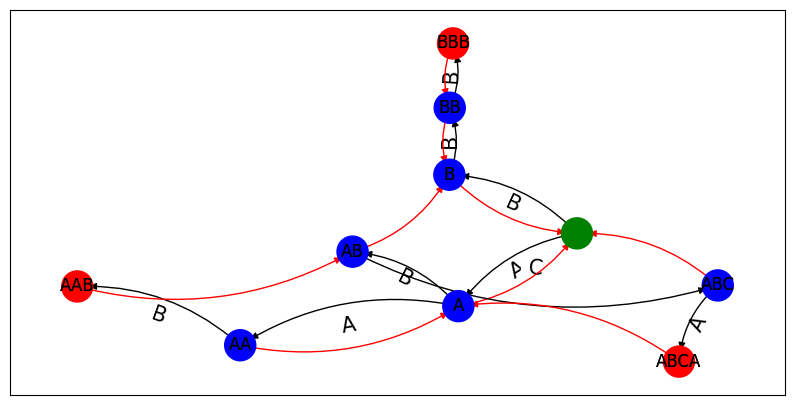

In [ ]:

arbre = Arbre(Noeud('',{}))
arbre.setWords(['BBB','AAB','ABCA'])
draw_graph(arbre)

In [ ]:

arbre = Arbre(Noeud('',{}))
# arbre.addWord('aac')
# arbre.addWord('agt')
# arbre.addWord('gta')
arbre.setWords(['aac','agt','gta'])

arbre.search('cagtaaccgta')

{'agt': [2], 'gta': [3, 9], 'aac': [5]}

#Analysis

## generating data

**generating DNA sequences of different lengths** and storing them in csv files !

In [ ]:
def generate_dna_sequence(length):
    return ''.join(random.choice('ACGT') for _ in range(length))

def generate_motif(seq, l):
    if l > len(seq):
        raise ValueError("Motif length cannot be greater than sequence length.")
    start = random.randint(0, len(seq) - l)
    motif = seq[start:start+l]
    return motif

In [ ]:
def write_to_csv(filename, data: str):
    file_exists = os.path.isfile(filename)
    with open(filename, 'a', newline='') as file:
        writer = csv.writer(file)
        if not file_exists:
            writer.writerow(["DNA Sequence"])
        if isinstance(data, str):
            writer.writerow([data])  # Write single row
        else:
            writer.writerows(data)

In [ ]:
l=50000000
i=0
for k in range(10):
  i+=1
  dna=generate_dna_sequence(l)
  write_to_csv(f"dna_{l}.csv",dna)

## **BOYER-MOORE** testing

**generating motifs from the dna sequences we have and testing them**


In [ ]:
def dna_sequence_generator(filename):
    for chunk in pd.read_csv(filename, header=None, names=['Sequence'], chunksize=1,skiprows=1):
        yield chunk['Sequence'].iloc[0]
motif_lenghts=[5,10,100,1000,10000,100000,1000000,10000000]
datas=[]

In [ ]:
i=50000000
filename = f'dna_{i}.csv'
sequences_generator = dna_sequence_generator(filename)
for sequence in sequences_generator:
  for v in motif_lenghts:
    if v==i:
      break
    motif=generate_motif(sequence,v)

    b_start=time.time()
    b_res,b_comp,dic=Boyer_Moore(sequence,motif)
    b_end=time.time()
    n_start=time.time()
    n_res,n_comp=naive_search(sequence,motif)
    n_end=time.time()

    b_execution=b_end-b_start
    n_execution=n_end-n_start
    pos=b_res
    data={
        'taille seq':i,
        'taille motif':v,
        'exec BM (secs)':b_execution,
        'exec naif (secs)':n_execution,
        'comps BM':b_comp,
        'comps naif':n_comp,
        'position':pos,
        'taille dic (octets)':sys.getsizeof(dic)

    }
    datas.append(data)

**creating a data frame to store the results**
it countains:
- length of the DNA sequence
- length of the motif
- execution time of Boyer-Moore (in seconds)(with the construction of the dictionary)
- execution time of naive-search (in seconds)
- number of comparisons of Boyer-Moore
- number of comparisons of naive search
- position of the motif in the DNA sequence (to find the worst and best case)
- size of the Boyer-Moore dictionary

In [ ]:
data_frame=pd.DataFrame(datas)
data_frame

,taille seq,taille motif,exec BM (secs),exec naif (secs),comps BM,comps naif,position,taille dic (octets)
0,10,5,0.000050,0.000008,5,5,0,640
1,10,5,0.000038,0.000007,5,5,0,640
2,10,5,0.000037,0.000010,10,12,4,360
3,10,5,0.000038,0.000010,6,11,4,640
4,10,5,0.000036,0.000008,6,6,1,640
...,...,...,...,...,...,...,...,...
355,50000000,1000,20.359284,28.851628,23012484,63599019,47695708,147552
356,50000000,10000,2.415761,7.518418,4275711,15237265,11420789,1310808
357,50000000,100000,3.737632,5.250573,3417812,8970236,6652696,20971608
358,50000000,1000000,5.208046,4.725670,3428036,13824209,9618673,167772256


on remarque que:
- le nombre de comparaisons faitent par boyer-moore est infereur a celui de naif sauf si le motif est a la postion **0**
- **le meilleur cas** de boyer-moore: le motif est a la premiere postion
- **le pire cas de boyer-moore** le motif est a la l-m'ieme postion et le décalage est toujours d'un caractère

**storing the data frame in a csv file**

In [ ]:
data_frame.to_csv('output.csv', index=False)

**sorting data and saving it in a new file**

In [ ]:
df_sorted = data_frame.sort_values(by=['taille seq', 'taille motif'])
df_sorted.to_csv('sorted_output.csv', index=False)

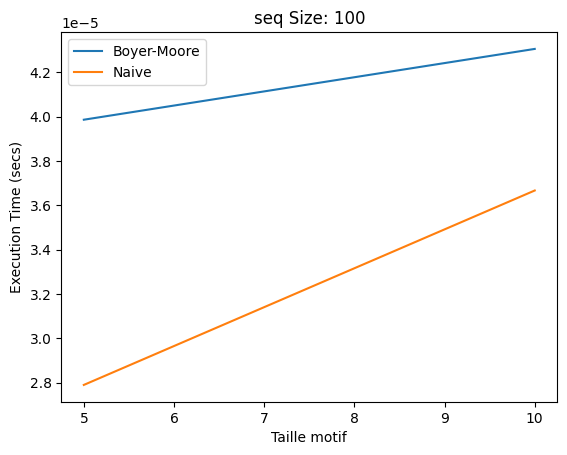

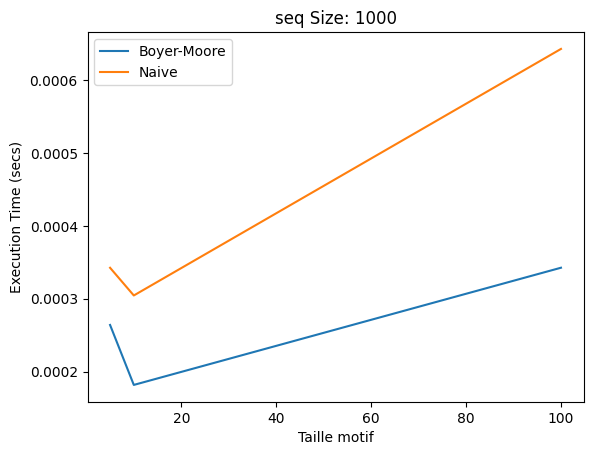

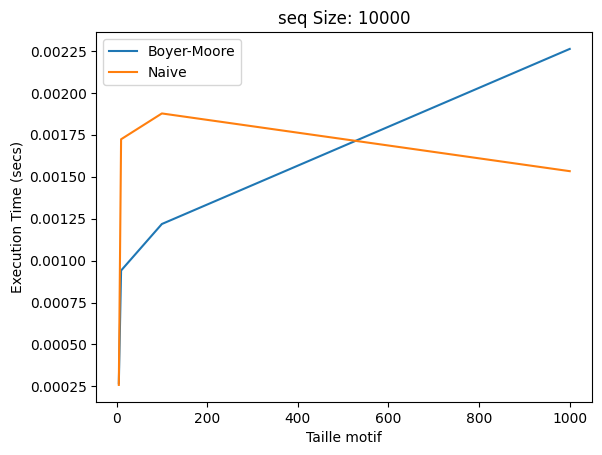

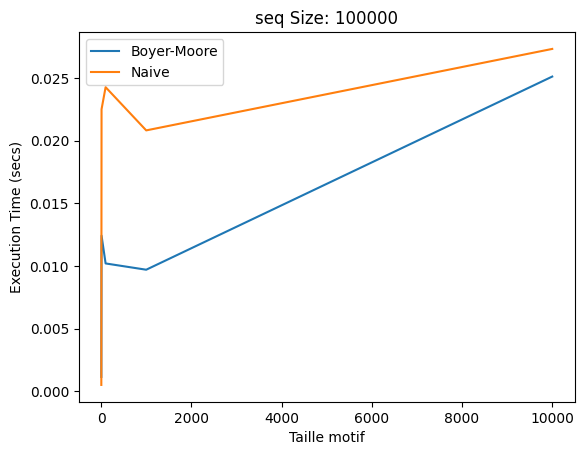

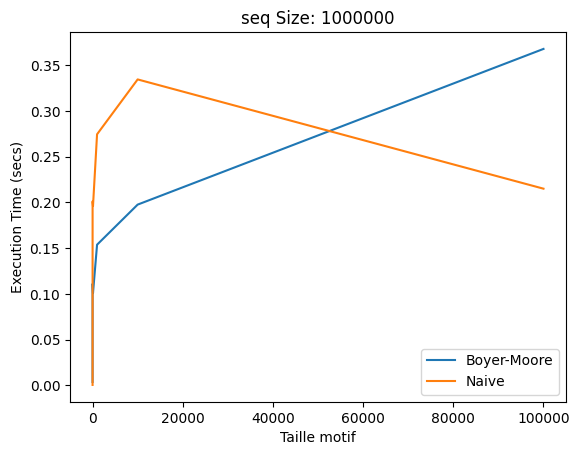

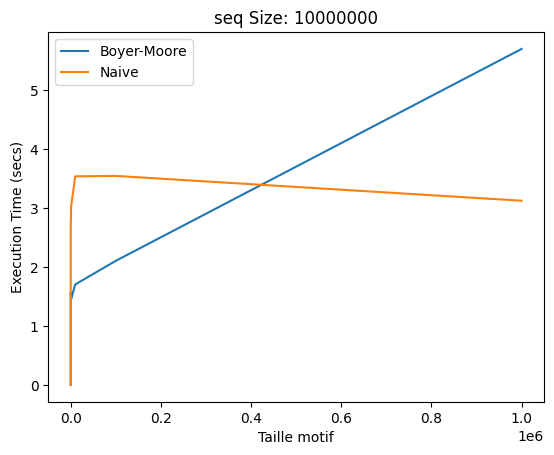

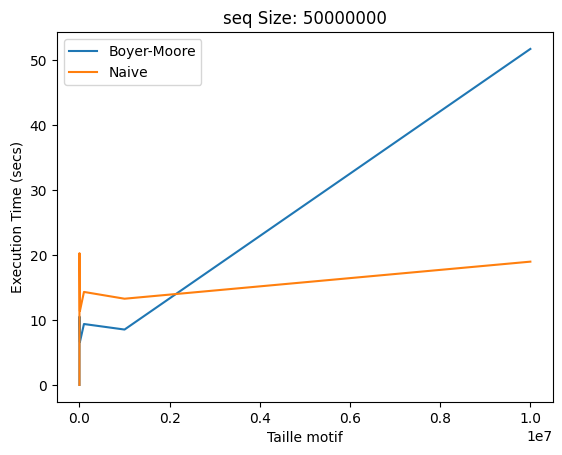

In [ ]:

unique_seq_sizes = [100,1000,10000,100000,1000000,10000000,50000000]

# Iterate over unique motif sizes
for motif_size in unique_seq_sizes:
    filtered_df = df_sorted[df_sorted['taille seq'] == motif_size]
    avg_execution_times_filtered = filtered_df.groupby('taille motif').agg({'exec BM (secs)': 'mean', 'exec naif (secs)': 'mean'})
    fig, ax = plt.subplots()
    ax.plot(avg_execution_times_filtered.index, avg_execution_times_filtered['exec BM (secs)'], label='Boyer-Moore')
    ax.plot(avg_execution_times_filtered.index, avg_execution_times_filtered['exec naif (secs)'], label='Naive')
    ax.set_xlabel('Taille motif')
    ax.set_ylabel('Execution Time (secs)')
    ax.set_title(f'seq Size: {motif_size}')
    ax.legend()
fig.show()

On remarque que:
- l'efficacité de Boyer-Moore diminue quand la taille du motif et proche a la taille de la sequence.
- pour chaque taille de motif au debut boyer moore prend moin de temps que naif jusqu'a arriver a une taille qui est presque egale a celle du motif.

## **RABIN-KARP** testing

In [ ]:
def get_first_value(dictionary):
    # Renvoie la première valeur du dictionnaire
    return next(iter(dictionary.values()))

In [ ]:
motif_lenghts=[5,10,100,1000,10000,100000,1000000,10000000]
data_RK=[]

In [ ]:
i=10000
filename = f'dna_{i}.csv'
b=10
q=11
sequences_generator = dna_sequence_generator(filename)
for sequence in sequences_generator:
  for v in motif_lenghts:
    if v==i:
      break
    motif=generate_motif(sequence,v)

    rk_start=time.time()
    rk_res,rk_comp,rk_faux_pos=rabin_karp(sequence,[motif],b,q)
    rk_end=time.time()
    n_start=time.time()
    n_res,n_comp=naive_search(sequence,motif)
    n_end=time.time()

    rk_execution=rk_end-rk_start
    n_execution=n_end-n_start
    pos=n_res
    data={
        'taille seq':i,
        'taille motif':v,
        'exec RK (secs)':rk_execution,
        'exec naif (secs)':n_execution,
        'comps RK':rk_comp,
        'comps naif':n_comp,
        'position':pos,
        'faux positifs':rk_faux_pos

    }
    data_RK.append(data)
data_frame_rk=pd.DataFrame(data_RK)
data_frame_rk

,taille seq,taille motif,exec RK (secs),exec naif (secs),comps RK,comps naif,position,faux positifs
0,10,5,0.000069,0.000010,6,11,4,1
1,10,5,0.000041,0.000008,5,7,2,0
2,10,5,0.000043,0.000008,5,6,1,0
3,10,5,0.000041,0.000006,5,6,1,0
4,10,5,0.000044,0.000007,5,8,2,0
...,...,...,...,...,...,...,...,...
188,10000,1000,0.115222,0.003076,2122,4158,2377,844
189,10000,5,0.019317,0.001295,1080,2185,1667,814
190,10000,10,0.022852,0.003588,1163,6042,4486,838
191,10000,100,0.029822,0.004131,1285,6887,5128,893


In [ ]:
data_frame_rk

,taille seq,taille motif,exec RK (secs),exec naif (secs),comps RK,comps naif,position,faux positifs
0,10,5,0.000069,0.000010,6,11,4,1
1,10,5,0.000041,0.000008,5,7,2,0
2,10,5,0.000043,0.000008,5,6,1,0
3,10,5,0.000041,0.000006,5,6,1,0
4,10,5,0.000044,0.000007,5,8,2,0
...,...,...,...,...,...,...,...,...
188,10000,1000,0.115222,0.003076,2122,4158,2377,844
189,10000,5,0.019317,0.001295,1080,2185,1667,814
190,10000,10,0.022852,0.003588,1163,6042,4486,838
191,10000,100,0.029822,0.004131,1285,6887,5128,893


on remarque que:
- les faux positif augmente avec l'augmentation de la taille des sequences
- le nombre de comparaison de rabin-karp est toujours inferieur au nombre de comparaisons faitent par l'algo naif

In [ ]:
data_frame_rk.to_csv('output_rk.csv', index=False)